# PART 1 - Merging marketing and churn datasets together

The idea for how this is accomplished is to use the synthetic_id column from each dataset. This will be described in further detail throughout the upcoming steps.

## Step 1) Linking Synthetic IDs

Take a synthetic ID from dataset A, then loop through dataset B and find the first iteration. Repeat this and build a merged dataframe from this that would have successfully merged the two datasets together. Ensure while going through, if a match is not found then skip over that ID and move onto the next one. 

NOTE: synthetic IDs are already in numerical order.

In [0]:
import pandas as pd

# Load datasets
df_a = pd.read_csv("/Volumes/dbdemos/default/test_infinitive_interns/bank_marketing_full.csv")
df_b = pd.read_csv("/Volumes/dbdemos/default/test_infinitive_interns/bank_churners_full.csv")

# Clean the synthetic_customer_id column
df_a['synthetic_customer_id'] = df_a['synthetic_customer_id'].astype(str).str.strip()
df_b['synthetic_customer_id'] = df_b['synthetic_customer_id'].astype(str).str.strip()

# Create lookup dictionary from Dataset B - store ALL rows for each ID in order
b_lookup = {}
for idx, row in df_b.iterrows():
    customer_id = row['synthetic_customer_id']
    if pd.notna(customer_id) and customer_id != 'nan':
        if customer_id not in b_lookup:
            b_lookup[customer_id] = []
        b_lookup[customer_id].append(row.to_dict())

# Track which occurrence we're on for each ID
id_occurrence_counter = {}
merged_rows = []

for idx_a, row_a in df_a.iterrows():
    customer_id = row_a['synthetic_customer_id']
    
    # Track which occurrence of this ID we're processing
    if customer_id not in id_occurrence_counter:
        id_occurrence_counter[customer_id] = 0
    else:
        id_occurrence_counter[customer_id] += 1
    
    current_occurrence = id_occurrence_counter[customer_id]
    
    # Start with all data from Dataset A
    merged_row = row_a.to_dict()
    
    # Look for match in Dataset B
    if customer_id in b_lookup:
        # Check if we have enough occurrences in Dataset B for this occurrence number
        if current_occurrence < len(b_lookup[customer_id]):
            # Match found - use the corresponding occurrence from Dataset B
            row_b = b_lookup[customer_id][current_occurrence]
            
            # Add columns from Dataset B (skip duplicate column names except merge key)
            for col, value in row_b.items():
                if col not in df_a.columns:
                    merged_row[col] = value
                elif col != 'synthetic_customer_id':  # Handle duplicate columns
                    merged_row[f"{col}_from_churners"] = value
        else:
            # No matching occurrence in Dataset B - add null values
            for col in df_b.columns:
                if col not in df_a.columns:
                    merged_row[col] = None
                elif col != 'synthetic_customer_id':
                    merged_row[f"{col}_from_churners"] = None
    else:
        # No match found at all - add null values for Dataset B columns
        for col in df_b.columns:
            if col not in df_a.columns:
                merged_row[col] = None
            elif col != 'synthetic_customer_id':
                merged_row[f"{col}_from_churners"] = None
    
    merged_rows.append(merged_row)

# Create final merged DataFrame
merged_df = pd.DataFrame(merged_rows)


## Step 2) Correct Positions

This block accomplishes taking the merged dataframe we just created and fixing the column headers to ensure that all the data points are in the correct positions. We do this manually to ensure it is validated.

In [0]:
%python 

import pandas as pd

# Read the CSV file with corrupted column names
df = pd.read_csv('/Volumes/dbdemos/default/test_infinitive_interns/bank_merged.csv')

# Define the correct column names in order
correct_column_names = [
    'age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 
    'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 
    'poutcome', 'deposit', 'synthetic_customer_id', 'customer_segment', 'age_group', 
    'income_tier', 'campaign_month_num', 'load_timestamp', 'source_file', 'record_hash',
    'CLIENTNUM', 'Attrition_Flag', 'Customer_Age', 'Gender', 'Dependent_count',
    'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category',
    'Months_on_book', 'Total_Relationship_Count', 'Months_Inactive_12_mon',
    'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal', 'Avg_Open_To_Buy',
    'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt', 'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1',
    'customer_segment_from_churners', 'age_group_from_churners', 'income_tier_from_churners',
    'credit_utilization_category', 'load_timestamp_from_churners', 'source_file_from_churners',
    'record_hashfrom_churners'
]

# Assign the correct column names
df.columns = correct_column_names

# Save the fixed CSV
df.to_csv('/Volumes/dbdemos/default/test_infinitive_interns/bank_merged_final.csv', index=False)

## Step 3) Heatmaps

Creating a heat map for the combined dataset (marketing and churn) to double validate the correlations of columns against one another.

/home/spark-56752268-add0-4cc2-8882-67/.ipykernel/2568/command-6968378671494402-3264298792:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


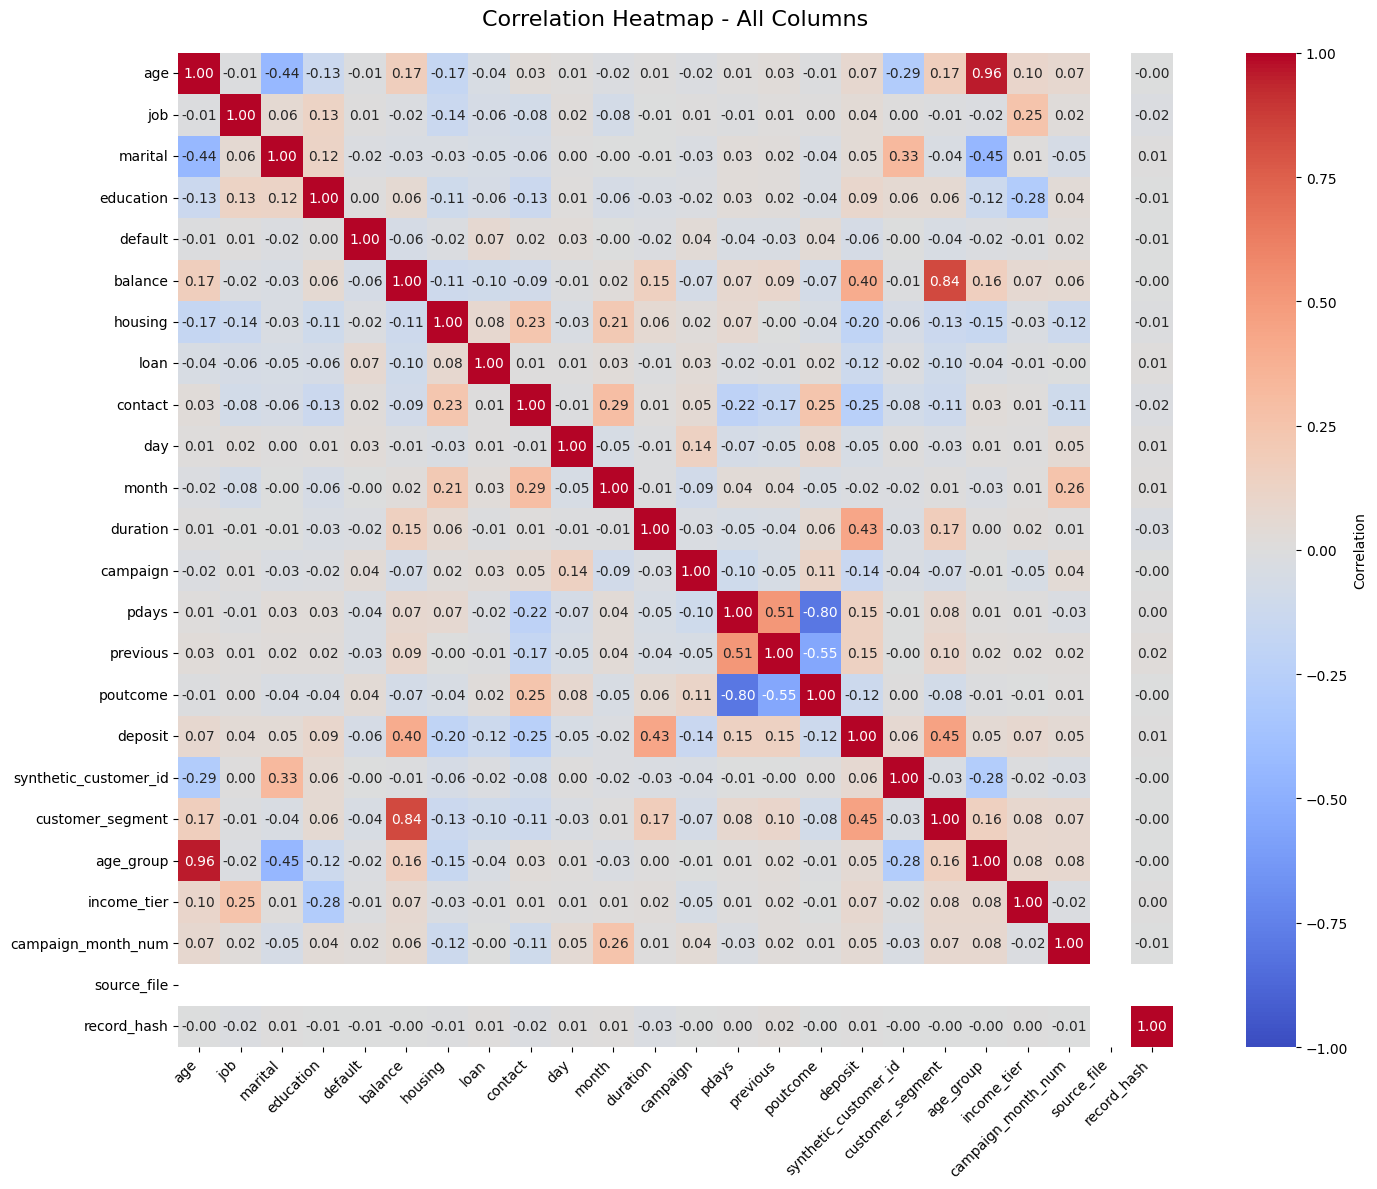

Highest correlations (excluding diagonal):
age       age_group                0.955563
balance   customer_segment         0.835379
pdays     previous                 0.512462
deposit   customer_segment         0.453422
duration  deposit                  0.432130
balance   deposit                  0.399123
marital   synthetic_customer_id    0.326374
contact   month                    0.289936
month     campaign_month_num       0.256672
job       income_tier              0.251853
dtype: float64


In [0]:
# Use correlation matrix for standardized relationships (-1 to 1)
corr_matrix = df.corr()

plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, 
            annot=True,
            fmt='.2f',
            cmap='coolwarm',
            center=0,
            square=True,
            vmin=-1, vmax=1,      # Correlation ranges from -1 to 1
            cbar_kws={'label': 'Correlation'})

plt.title('Correlation Heatmap - All Columns', fontsize=16, pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Print highest correlations
print("Highest correlations (excluding diagonal):")
mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
corr_values = corr_matrix.where(mask).stack().sort_values(ascending=False)
print(corr_values.head(10))

# PART 2 - Marketing Dataset

## Step 1) Refining Marketing Dataset

Now let's focus on the marketing dataset. We wish to filter out the rows where the poutcome is NOT equal to 3 and 1. This will allow us to view the dataset with how we wish. We want to remove when the poutcomes are other and unknowns.

In [0]:
import pandas as pd

# Load the encoded dataset
path = "/Volumes/dbdemos/default/test_infinitive_interns/bank_marketing_encoded.csv"
spark_df = spark.read.csv(path, header=True, inferSchema=True)
df = spark_df.toPandas()

# Filter out rows where poutcome != 3
df_filtered = df[df['poutcome'] != 3].copy()
df_filtered_2 = df_filtered[df_filtered['poutcome'] != 1].copy()

# Reset index after filtering
df_filtered = df_filtered.reset_index(drop=True)

# Save the filtered dataset
output_path = "/Volumes/dbdemos/default/test_infinitive_interns/bank_marketing_poutcomes.csv"
df_filtered.to_csv(output_path, index=False)

Create a new heatmap for this new filtered down dataset.

/home/spark-dd5db6bf-eb62-42ab-b394-2e/.ipykernel/16532/command-6968378671494411-894214900:19: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_filtered.corr()


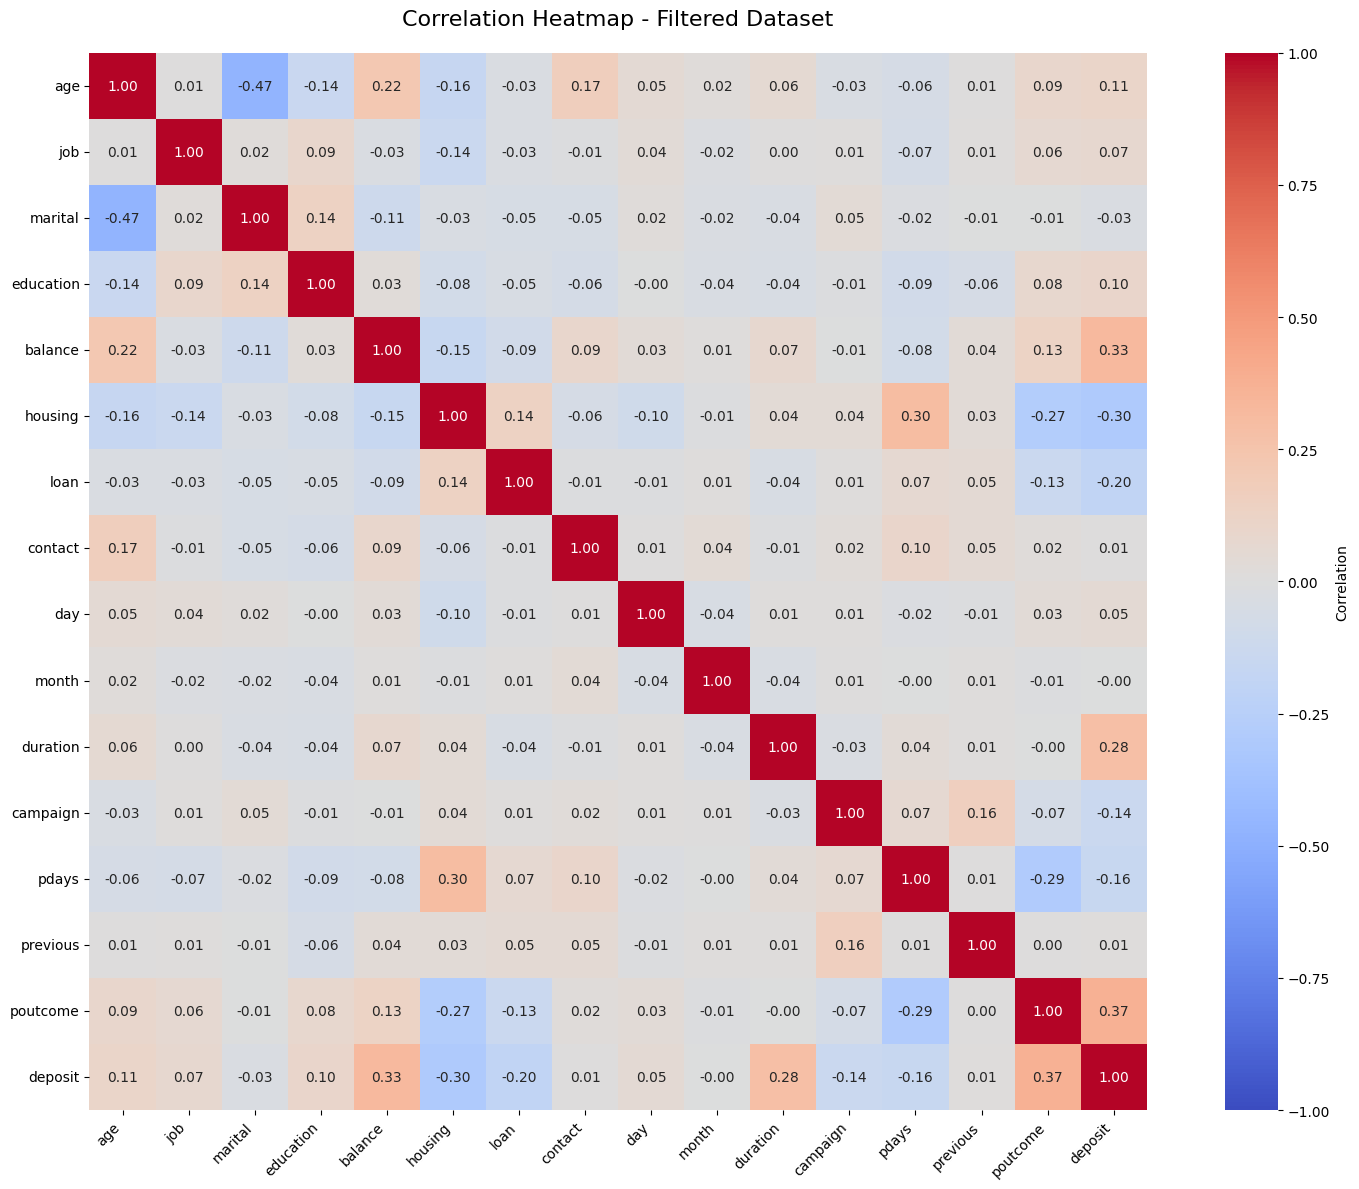

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Load the filtered dataset
path = "/Volumes/dbdemos/default/test_infinitive_interns/bank_marketing_poutcomes.csv"
spark_df = spark.read.csv(path, header=True, inferSchema=True)
df = spark_df.toPandas()

# Columns to exclude
exclude_cols = ['default', 'synthetic_customer_id', 'campaign_month_num', 
                'source_file', 'record_hash', 'income_tier', 'age_group', 'customer_segment']

# Drop those columns from the DataFrame
df_filtered = df.drop(columns=exclude_cols, errors='ignore')

# Compute correlation matrix
corr_matrix = df_filtered.corr()

# Create correlation heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, 
            annot=True,
            fmt='.2f',
            cmap='coolwarm',
            center=0,
            square=True,
            vmin=-1, vmax=1,
            cbar_kws={'label': 'Correlation'})

plt.title('Correlation Heatmap - Filtered Dataset', fontsize=16, pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()
